### Script to generate a PCA of Plankton Dataset clustered by a pretrained NN
Prerequesits: a pretrained NN. In our case this was a modifified version of ResNet-50, specifically modified to work with single channel grayscale images that were fed to the NN in their real size during training.

In [7]:
import torch
from torch import optim, nn
from torchvision import models, transforms, datasets
from tqdm import tqdm
import numpy as np
import os
import cv2

In [8]:
class resnet_1ch(models.resnet.ResNet):

    def __init__(self, block, layers, num_classes=2):
        self.inplanes = 64
        super(resnet_1ch, self).__init__(block, layers)
        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
# instantiate a resnet50 with bottleneck according to: https://github.com/pytorch/vision/blob/791c172a337d98012018f98ffde93b1020ba3ed5/torchvision/models/resnet.py#L236
model_fresh = resnet_1ch(models.resnet.Bottleneck, [3, 4, 6, 3])

In [9]:
class FeatureExtractor(nn.Module):
  def __init__(self, model):
    super(FeatureExtractor, self).__init__()
		# Extract VGG-16 Feature Layers
    #self.features = list(model.features) #for vgg16
    self.features = list(model.children())[:-1] #for resnet
    self.features = nn.Sequential(*self.features)
		# Extract VGG-16 Average Pooling Layer
    self.pooling = model.avgpool
		# Convert the image into one-dimensional vector
    self.flatten = nn.Flatten()
		# Extract the first part of fully-connected layer from VGG16
    #self.fc = model.classifier[0] #vgg16
    
  
  def forward(self, x):
		# It will take the input 'x' until it returns the feature vector called 'out'
    out = self.features(x)
    out = self.pooling(out)
    out = self.flatten(out)
    #out = self.fc(out) 
    return out 

# Initialize the model
#model = models.vgg16(weights='VGG16_Weights.DEFAULT')
model = resnet_1ch(models.resnet.Bottleneck, [3, 4, 6, 3])
num_ftrs = model.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model.fc = nn.Linear(num_ftrs, 2)
model.load_state_dict(torch.load('/home/plankton/Data/resnet50_copepod_1ch_sd.pth'))
model.eval()
new_model = FeatureExtractor(model)

# Change the device to GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")
new_model = new_model.to(device)

In [11]:
# Data augmentation and normalization 
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224,224)),
        #transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(degrees=(0, 180)),
        transforms.Grayscale(),
        transforms.ToTensor(),
        transforms.Normalize([0.485,
        #0.456, 
        #0.406
        ], 
        [0.229, 
        #0.224, 
        #0.225
        ])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224,224)),
        #transforms.CenterCrop(224),
        transforms.Grayscale(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 
        #0.456, 
        #0.406
        ], [0.229, 
        #0.224, 
        #0.225
        ])
    ]),
}

data_dir = '/home/plankton/Data/labeled_plankton'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(
    image_datasets[x], 
    batch_size=8,
    shuffle=True, 
    num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

In [12]:
labels_i=[]
for i in image_datasets['val']:
    labels_i.append(i[1])

labels_i = np.array(labels_i)
#labels_i

In [15]:
data_dir_new = '/home/plankton/Results/Peru_MedianSegmenter/crops/15_03_2020/M2'
data_dir_old = os.listdir(os.path.join(data_dir,'val/copepod'))

Calculate the features

In [16]:

# Transform the image, so it becomes readable with the model

transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224,224)),
        #transforms.CenterCrop(224),
        transforms.Grayscale(),
        transforms.ToTensor(),
  ]
)

# Will contain the features
features = []

# Iterate each image
for i in tqdm(os.listdir(data_dir_new)):
  if i.endswith('.jpg'):
    # Set the image path
    path = os.path.join(data_dir_new, str(i))
    # Read the file
    img = cv2.imread(path)
    #print(img)
    # Transform the image
    img = transform(img)
    # Reshape the image. PyTorch model reads 4-dimensional tensor
    # [batch_size, channels, width, height]
    img = img.reshape(1, 1, 224, 224) #448 for vgg16
    img = img.to(device)
    # We only extract features, so we don't need gradient
    with torch.no_grad():
      # Extract the feature from the image
      feature = new_model(img)
    # Convert to NumPy Array, Reshape it, and save it to features variable
    features.append(feature.cpu().detach().numpy().reshape(-1))
  else:
    pass

# Convert to NumPy Array
features = np.array(features)

100%|██████████| 65408/65408 [07:43<00:00, 141.12it/s]


In [19]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
features_r = pca.fit(features).transform(features)

# Percentage of variance explained for each components
print(
    "explained variance ratio (first two components): %s"
    % str(pca.explained_variance_ratio_)
)


explained variance ratio (first two components): [0.55235714 0.14678332]


100%|██████████| 65118/65118 [00:43<00:00, 1489.89it/s]


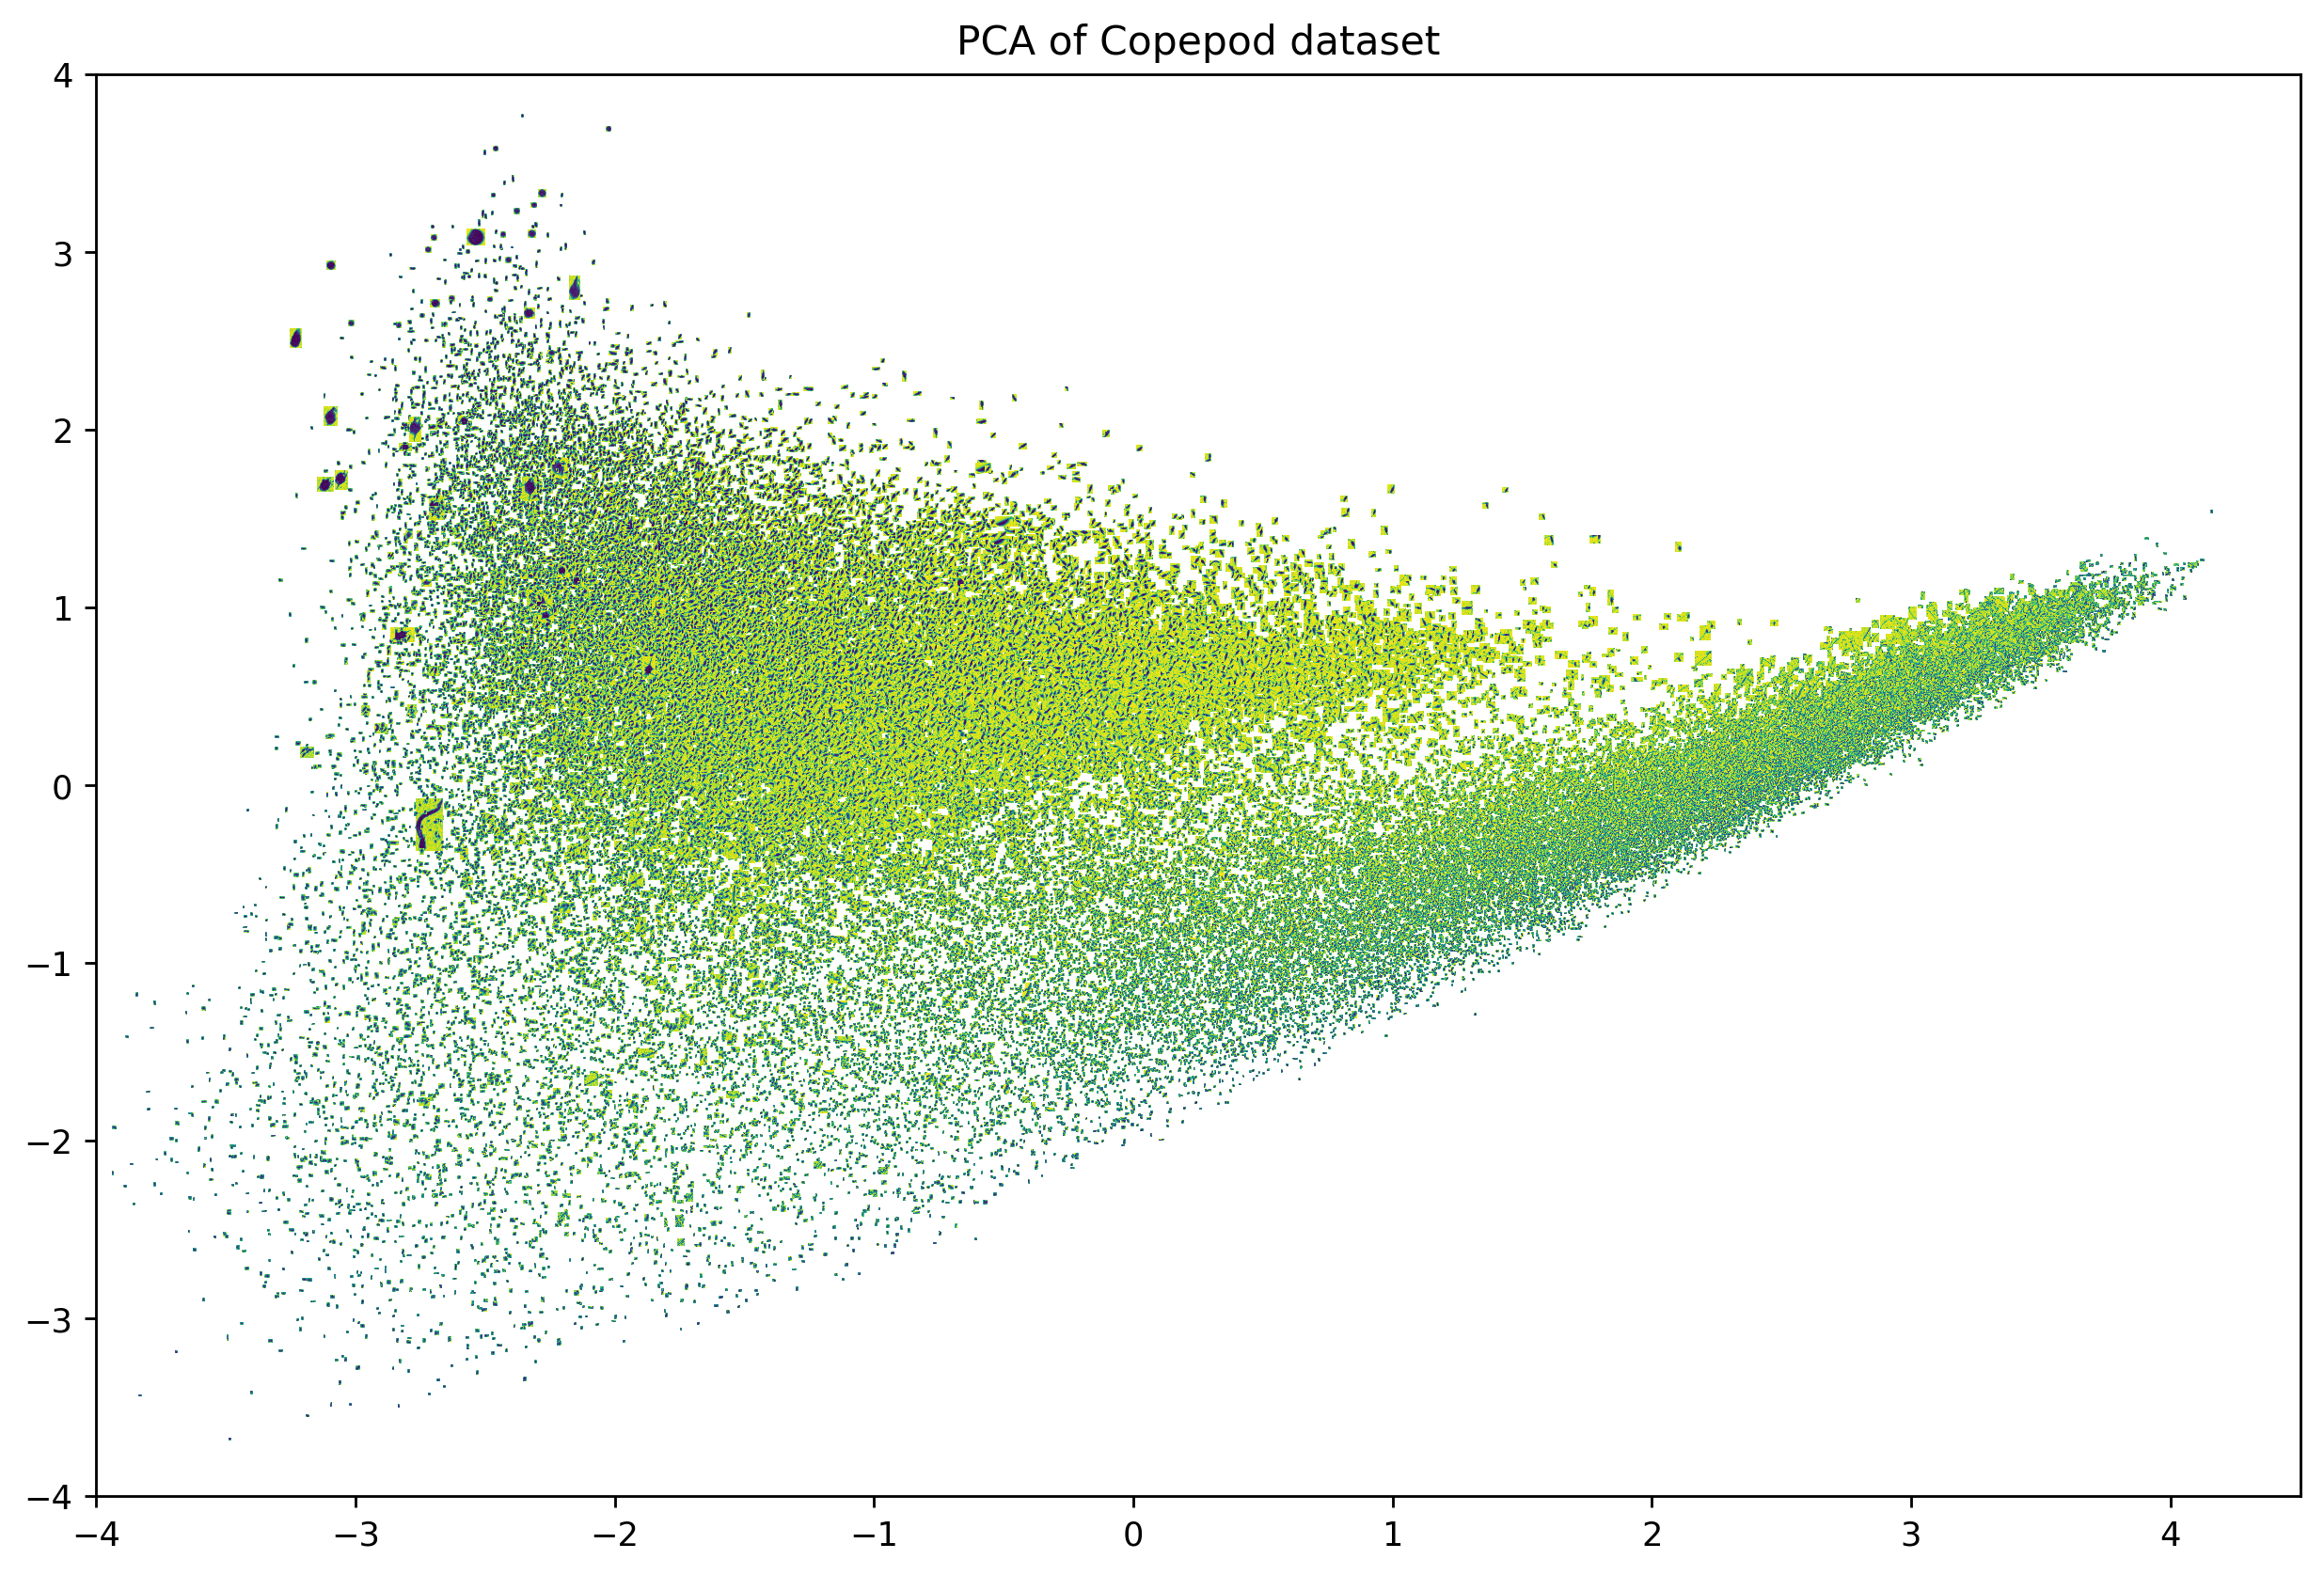

In [20]:

from matplotlib.offsetbox import (OffsetImage, AnnotationBbox)
import glob

jpgFilenamesList = glob.glob('*.jpg',root_dir=data_dir_new)
mydpi=254
fig, ax = plt.subplots(figsize=(3024/mydpi,1964/mydpi),dpi=mydpi)

for i,k in zip(tqdm(jpgFilenamesList),range(len(jpgFilenamesList))):
    if i.endswith('.jpg'):
        img = cv2.imread(os.path.join(data_dir_new,i))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = np.asarray(img)
        imagebox = OffsetImage(img, zoom = 0.05)
        imagebox.image.axes = ax
        ab = AnnotationBbox(imagebox, (features_r[k, 0], features_r[k, 1]), frameon = False)
        ax.add_artist(ab)
    else:
        pass

#for i,k in zip(tqdm(os.listdir(os.path.join(data_dir,'val/copepod'))),range(len(os.listdir(os.path.join(data_dir,'val/copepod'))))):
#    if i.endswith('.jpg'):
#        img = plt.imread(os.path.join(data_dir,'val/copepod',i))
#        imagebox = OffsetImage(img, zoom = 0.05)
#        imagebox.image.axes = ax
#        ab = AnnotationBbox(imagebox, (features_r[k, 0], features_r[k, 1]), frameon = False)
#        ax.add_artist(ab)
#    else:
#        pass

#plt.legend(loc="best", shadow=False, scatterpoints=1)
ax.set_xlim(-4, 4.5)
ax.set_ylim(-4, 4)
plt.title("PCA of Copepod dataset")
plt.show()

## further experiments





In [104]:
len(features)

65118

In [50]:
from sklearn.cluster import KMeans

# Initialize the model
model = KMeans(n_clusters=2, random_state=42)

# Fit the data into the model
model.fit(features)
labels = model.labels_

In [105]:
from sklearn.cluster import DBSCAN

db = DBSCAN(eps=2, min_samples=10).fit(features)
labels = np.asarray(db.labels_)
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

Estimated number of clusters: 1
Estimated number of noise points: 1


In [161]:
print(np.unique(labels)) # [4 3 3 ... 0 0 0]

-1


In [107]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
features_r = pca.fit(features).transform(features)

# Percentage of variance explained for each components
print(
    "explained variance ratio (first two components): %s"
    % str(pca.explained_variance_ratio_)
)


explained variance ratio (first two components): [0.5523571  0.14678349]


In [130]:
features_r[:,1].min()

-3.68473

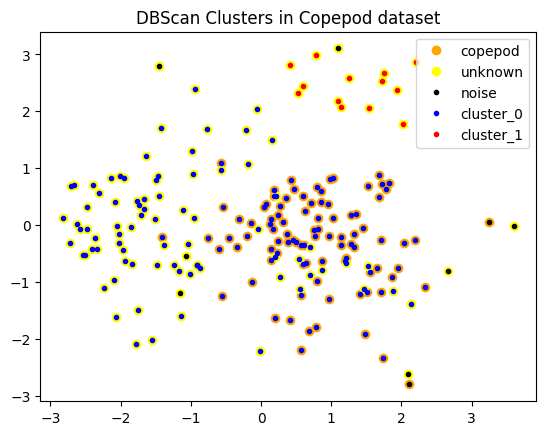

In [95]:
plt.figure()
colors = ["orange", "yellow"]
lw = 2

for color, i, target_name in zip(colors, [0, 1], class_names):
    plt.plot(
        features_r[labels_i==i, 0], features_r[labels_i==i, 1], 'o', color=color, lw=lw, label=target_name, 
    )
plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.title("DBScan Clusters in Copepod dataset")

clusters = np.unique(labels)
colors = ['black',
'blue',
'red',
'green',
#'purple',
#'orange'
]
c_names = ['noise','cluster_0','cluster_1','cluster_3']

for color, i, cluster  in zip(colors, clusters, c_names):
    plt.plot(
        features_r[labels==i, 0], features_r[labels==i, 1], 'o', color=color, alpha=1, lw=1, label = cluster, markersize = 3, 
    )
plt.legend(loc="best", shadow=False, scatterpoints=1)
#plt.title("PCA of Copepod dataset")

plt.show()

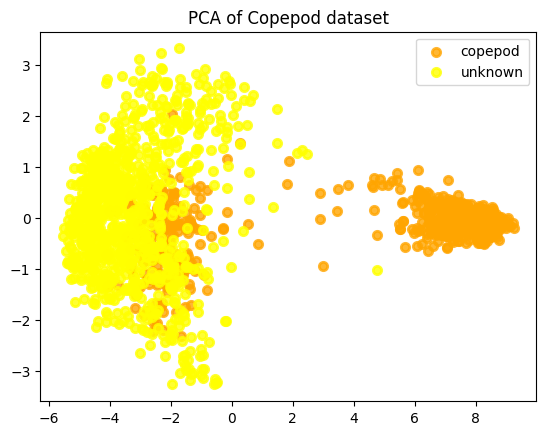

In [76]:
plt.figure()
colors = ["orange", "yellow"]
lw = 2

for color, i, target_name in zip(colors, [0, 1], class_names):
    plt.scatter(
        features_r[labels_i==i, 0], features_r[labels_i==i, 1], color=color, alpha=0.8, lw=lw, label=target_name
    )
plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.title("PCA of Copepod dataset")
plt.show()

In [86]:
x = len(os.listdir(os.path.join(data_dir,'train/copepod')))
x

644

100%|██████████| 65118/65118 [00:36<00:00, 1806.90it/s]


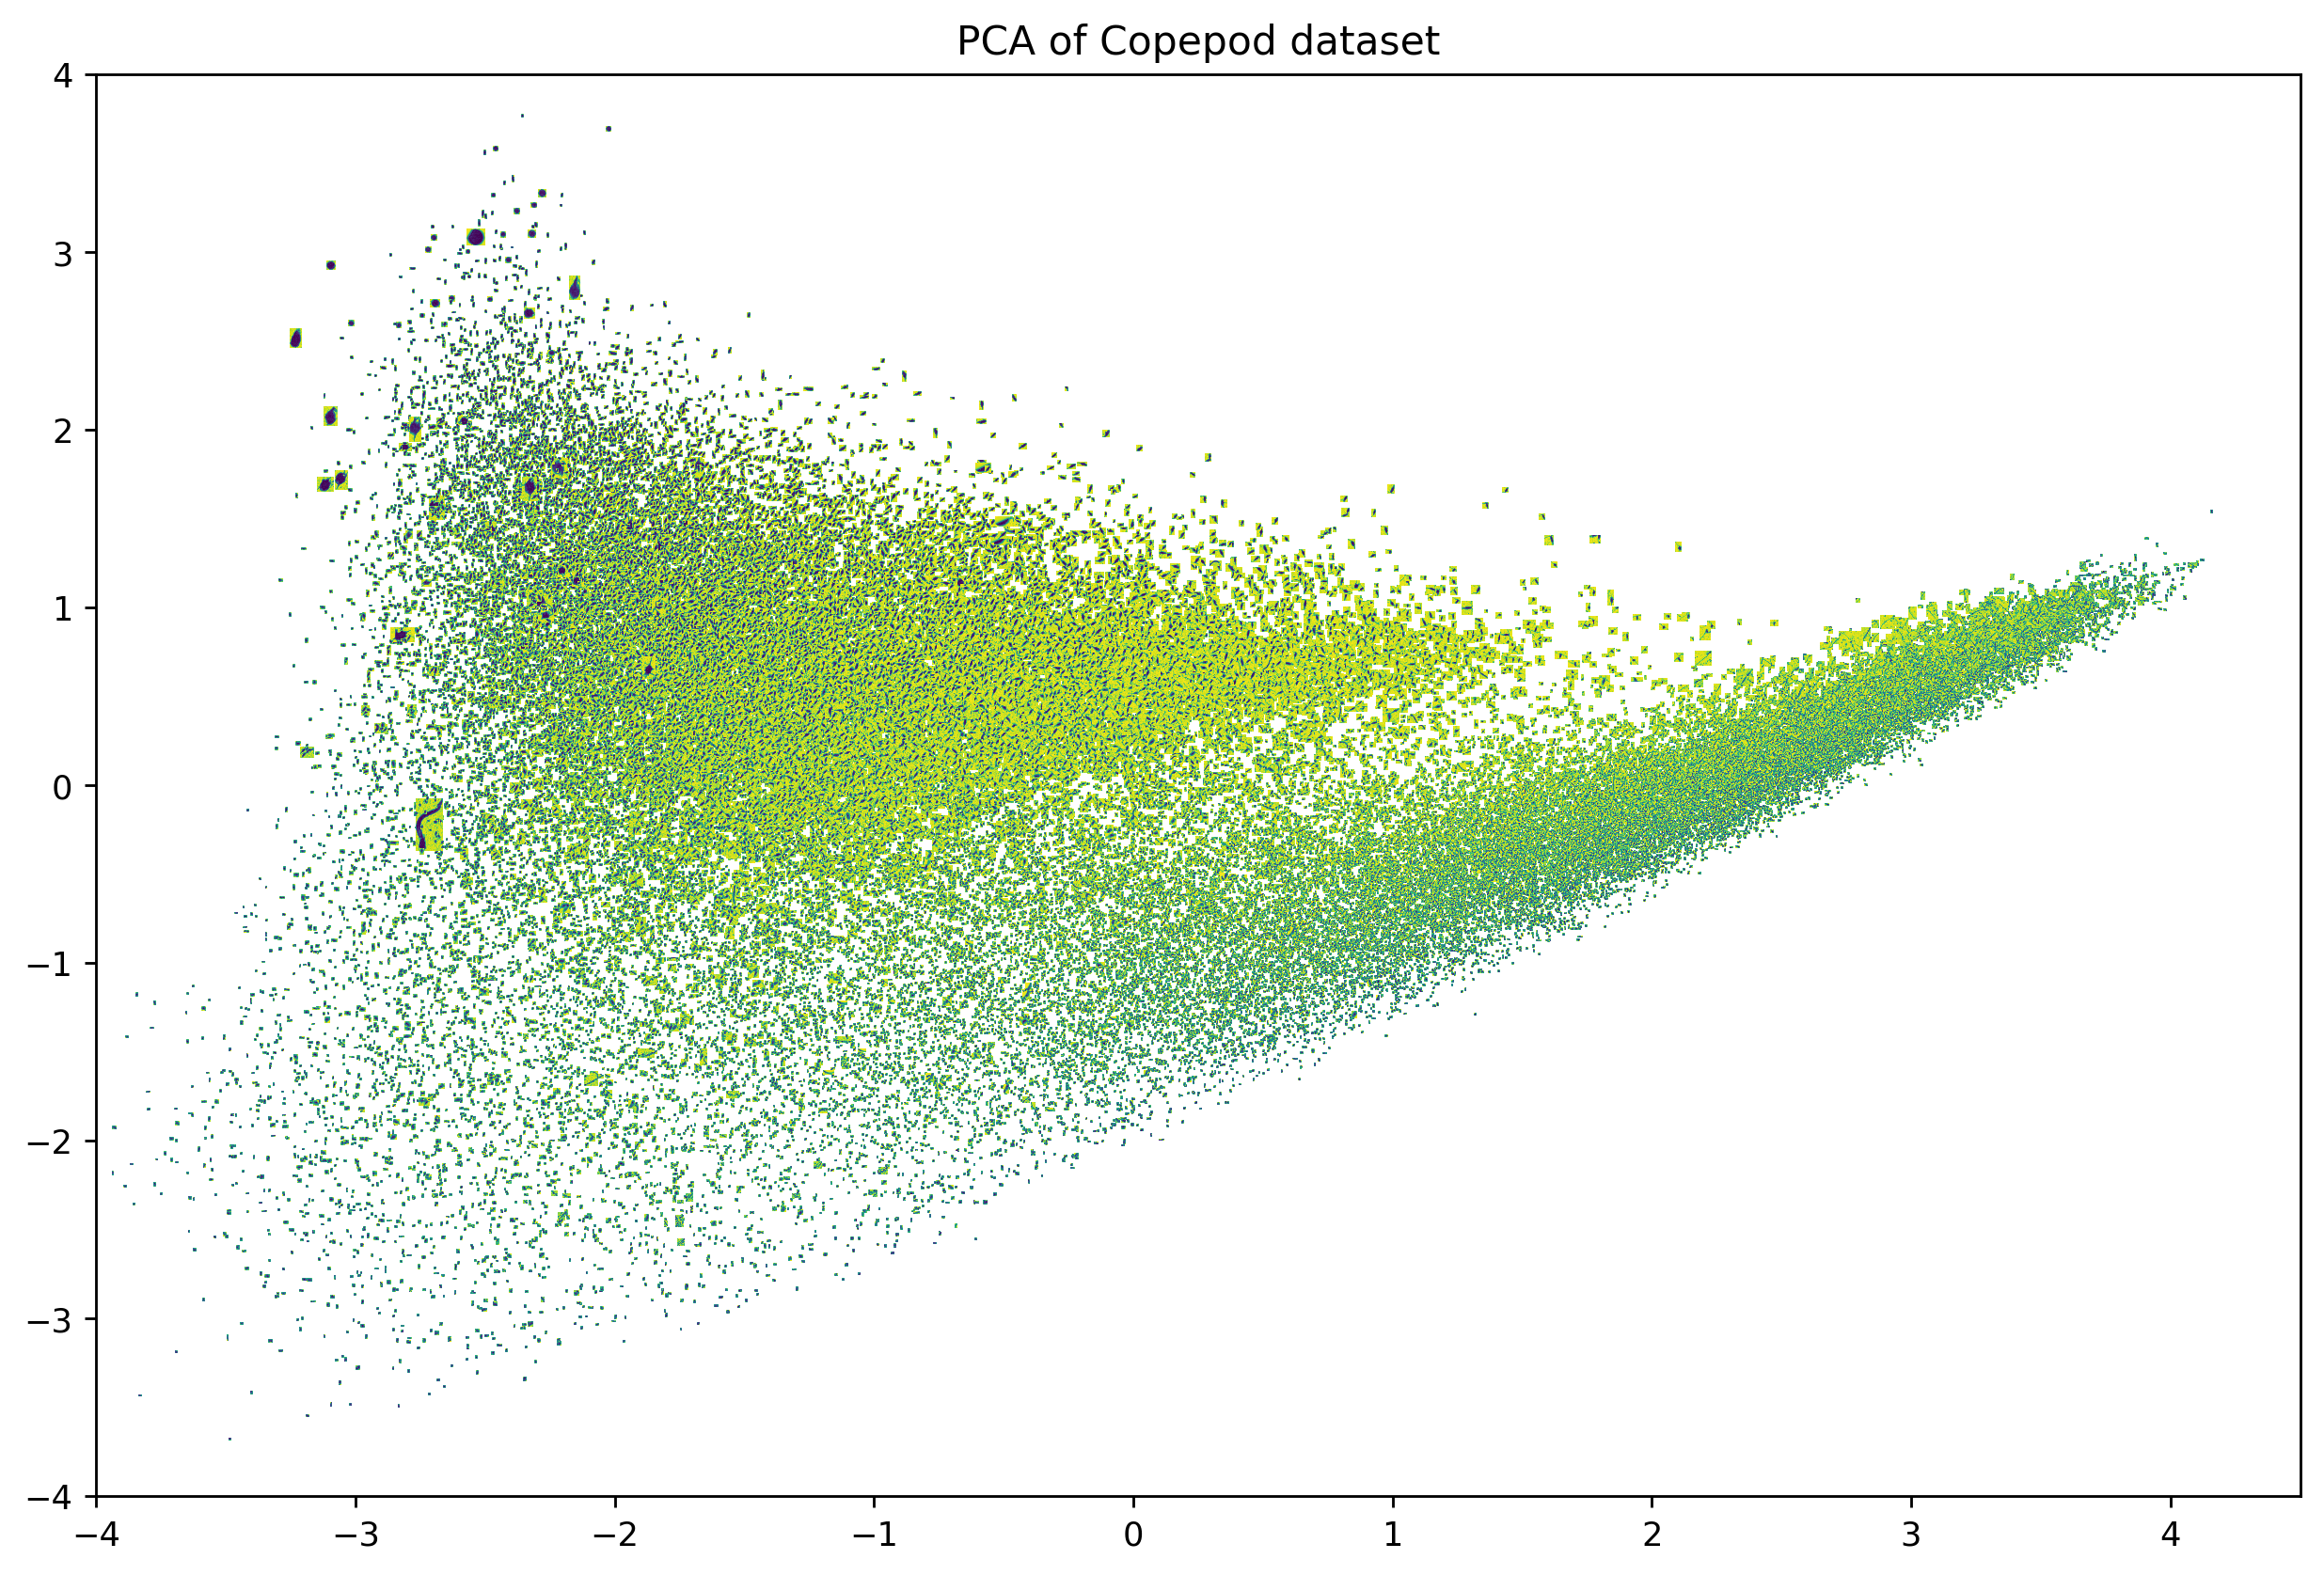

In [133]:
from matplotlib.offsetbox import (OffsetImage, AnnotationBbox)
import glob

jpgFilenamesList = glob.glob('*.jpg',root_dir=data_dir_new)
mydpi=254
fig, ax = plt.subplots(figsize=(3024/mydpi,1964/mydpi),dpi=mydpi)

for i,k in zip(tqdm(jpgFilenamesList),range(len(jpgFilenamesList))):
    if i.endswith('.jpg'):
        img = cv2.imread(os.path.join(data_dir_new,i))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = np.asarray(img)
        imagebox = OffsetImage(img, zoom = 0.05)
        imagebox.image.axes = ax
        ab = AnnotationBbox(imagebox, (features_r[k, 0], features_r[k, 1]), frameon = False)
        ax.add_artist(ab)
    else:
        pass

#for i,k in zip(tqdm(os.listdir(os.path.join(data_dir,'val/copepod'))),range(len(os.listdir(os.path.join(data_dir,'val/copepod'))))):
#    if i.endswith('.jpg'):
#        img = plt.imread(os.path.join(data_dir,'val/copepod',i))
#        imagebox = OffsetImage(img, zoom = 0.05)
#        imagebox.image.axes = ax
#        ab = AnnotationBbox(imagebox, (features_r[k, 0], features_r[k, 1]), frameon = False)
#        ax.add_artist(ab)
#    else:
#        pass

#plt.legend(loc="best", shadow=False, scatterpoints=1)
ax.set_xlim(-4, 4.5)
ax.set_ylim(-4, 4)
plt.title("PCA of Copepod dataset")
plt.show()